# Hybrid control of inverted pendulum

## Components

In [2]:
from sympy import *

In [3]:
# state variable, time, and control input
Theta = Function('\\theta')
t, delta, t1 = symbols(['t', '\\Delta', 't_1'], positive=True)
u = symbols('u')

In [4]:
# equation of motion
ddtheta =  sin(Theta(t)) - u*cos(Theta(t))
ddtheta

-u*cos(\theta(t)) + sin(\theta(t))

In [5]:
# energy
E = Theta(t).diff(t)**2/2 + cos(Theta(t)) - 1
E

cos(\theta(t)) + Derivative(\theta(t), t)**2/2 - 1

In [6]:
dE = E.diff(t)
dE

-sin(\theta(t))*Derivative(\theta(t), t) + Derivative(\theta(t), t)*Derivative(\theta(t), (t, 2))

In [7]:
# lyapunov
VE = E**2/2
VE

(cos(\theta(t)) + Derivative(\theta(t), t)**2/2 - 1)**2/2

In [8]:
dVE = VE.diff(t).simplify()
dVE

-(sin(\theta(t)) - Derivative(\theta(t), (t, 2)))*(2*cos(\theta(t)) + Derivative(\theta(t), t)**2 - 2)*Derivative(\theta(t), t)/2

In [11]:
l0, l1 = symbols('l_0 l_1', real=True, positive=True)
VL = l0*Theta(t) + l1*Theta(t).diff(t)**2
VL

l_0*\theta(t) + l_1*Derivative(\theta(t), t)**2

In [12]:
dVL = VL.diff(t)
dVL

l_0*Derivative(\theta(t), t) + 2*l_1*Derivative(\theta(t), t)*Derivative(\theta(t), (t, 2))

In [13]:
dVL = dVL.subs(Theta(t).diff(t,2), ddtheta).simplify()
dVL

(l_0 - 2*l_1*(u*cos(\theta(t)) - sin(\theta(t))))*Derivative(\theta(t), t)

In [14]:
kp, kv = symbols('k_p k_v', real=True, positive=True)
uL = kp*sin(Theta(t)) + kv*Theta(t).diff(t)
uL

k_p*sin(\theta(t)) + k_v*Derivative(\theta(t), t)

In [15]:
dVL.subs(u, uL).expand()

-2*k_p*l_1*sin(\theta(t))*cos(\theta(t))*Derivative(\theta(t), t) - 2*k_v*l_1*cos(\theta(t))*Derivative(\theta(t), t)**2 + l_0*Derivative(\theta(t), t) + 2*l_1*sin(\theta(t))*Derivative(\theta(t), t)

## State-space form

In [16]:
theta, omega, alpha = symbols(['\\theta', '\\dot{\\theta}', '\\ddot{\\theta}'])
x = Matrix([theta, omega])
f = Matrix([
    omega, 
    ddtheta.subs(Theta(t), theta)])
f
# print(latex(f))
# print(latex(Matrix([omega, alpha])))
# solve(f)

Matrix([
[                \dot{\theta}],
[-u*cos(\theta) + sin(\theta)]])

In [17]:
ddtheta = ddtheta.subs(Theta(t), theta)
ddtheta
# print(latex(ddtheta))

-u*cos(\theta) + sin(\theta)

In [18]:
E = E.subs(Theta(t).diff(t), omega).subs(Theta(t), theta).simplify()
E
# print(latex(E))

\dot{\theta}**2/2 + cos(\theta) - 1

In [19]:
dE = dE.subs(Theta(t).diff(t,2), alpha).subs(Theta(t).diff(t), omega).subs(Theta(t), theta)
dE

\ddot{\theta}*\dot{\theta} - \dot{\theta}*sin(\theta)

In [20]:
VE = VE.subs(Theta(t).diff(t), omega).subs(Theta(t), theta).simplify()
VE
# print(latex(VE))

(\dot{\theta}**2 + 2*cos(\theta) - 2)**2/8

In [21]:
dVE = dVE.subs(Theta(t).diff(t,2), alpha).subs(Theta(t).diff(t), omega).subs(Theta(t), theta).simplify()
dVE
# print(latex(dVE))

\dot{\theta}*(\ddot{\theta} - sin(\theta))*(\dot{\theta}**2 + 2*cos(\theta) - 2)/2

In [22]:
dVE = dVE.subs(alpha, ddtheta).simplify()
dVE
# print(latex(dVE))

\dot{\theta}*u*(-\dot{\theta}**2 - 2*cos(\theta) + 2)*cos(\theta)/2

## Control

In [23]:
k = symbols('k', positive=True)
uE = k*E*omega*cos(theta)
uE = uE.simplify()
uE
# print(latex(uE))

\dot{\theta}*k*(\dot{\theta}**2 + 2*cos(\theta) - 2)*cos(\theta)/2

In [24]:
dVE = dVE.subs(u, uE).simplify()
dVE
# print(latex(dVE))

-\dot{\theta}**2*k*(\dot{\theta}**2 + 2*cos(\theta) - 2)**2*cos(\theta)**2/4

In [25]:
f = f.subs(u, uE)
f

Matrix([
[                                                                        \dot{\theta}],
[-\dot{\theta}*k*(\dot{\theta}**2 + 2*cos(\theta) - 2)*cos(\theta)**2/2 + sin(\theta)]])

In [145]:
solve(sqrt((acos(cos(theta))*2*pi/4)**2 + omega**2) - k, omega)

[-sqrt(4*k**2 - pi**2*acos(cos(\theta))**2)/2,
 sqrt(4*k**2 - pi**2*acos(cos(\theta))**2)/2]

In [ ]:
    d = np.arccos(np.cos(theta))
    d = omega**2 + (d*2*np.pi/4)**2
    d = np.sqrt(d)

## Linear controller

In [ ]:
solve(dVE, [theta, omega])

## Simulation

In [29]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [30]:
# state-space dynamics
def f(x, u):
    theta, omega = x[0], x[1]
    return np.array([
        omega,
        np.sin(theta) - u*np.cos(theta)
    ])

In [31]:
# energy
def E(x):
    theta, omega = x[0], x[1]
    return 0.5*omega**2 + np.cos(theta) - 1

In [58]:
def _pi(x):
    theta, omega = x[0], x[1]
    d = (np.cos(theta) - 1)**2
    d += omega**2
    d = np.sqrt(d)
    if d < 1:
        u = 2*np.sin(theta) + 0.5*omega
    else:
        u = E(x)*np.sign(omega*np.cos(theta))
    return np.clip(u, -1, 1)
pi = lambda x: np.apply_along_axis(_pi, 0, x)

In [59]:
sol = solve_ivp(
    lambda t, x: f(x, pi(x)),
    (0.0, 40.0),
    np.array([np.pi - 0.0001, 0.0]),
    method='DOP853',
    atol=1e-12, 
    rtol=1e-12,
)
sol.u = np.apply_along_axis(pi, 0, sol.y)
sol.E = np.apply_along_axis(E, 0, sol.y)

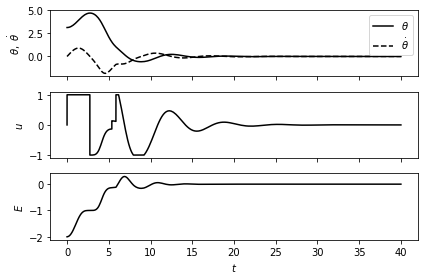

In [60]:
fig, ax = plt.subplots(3, sharex=True)

# angle and velocity
ax[0].plot(sol.t, sol.y[0], 'k-', label='$\\theta$')
ax[0].plot(sol.t, sol.y[1], 'k--', label='$\\dot{\\theta}$')
ax[0].legend()
ax[0].set_ylabel('$\\theta, ~ \\dot{\\theta}$')

ax[1].plot(sol.t, sol.u, 'k-')
# ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$u$')

ax[2].plot(sol.t, sol.E, 'k-')
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$E$')
plt.tight_layout()
# fig.savefig('../img/swingup.pdf', bbox_inches='tight')
plt.show()

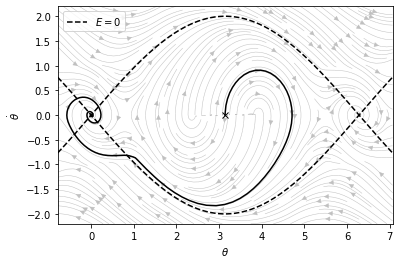

In [61]:
fig, ax = plt.subplots(1)

# hybrid trajectory
ax.plot(sol.y[0, 0], sol.y[1, 0], 'kx')
ax.plot(sol.y[0], sol.y[1], 'k-')

# 0-energy curve
n = 1000
statesn = np.vstack((
    np.linspace(-np.pi/4, 2*np.pi + np.pi/4, n), 
    np.linspace(-2.2, 2.2, n)
))
ax.plot(statesn[0], np.sqrt(2 - 2*np.cos(statesn[0])), 'k--', label='$E = 0$')
ax.plot(statesn[0], -np.sqrt(2 - 2*np.cos(statesn[0])), 'k--')

# vector field
m = 100
statesm = np.vstack((
    np.linspace(-np.pi/4, 2*np.pi + np.pi/4, m), 
    np.linspace(-2.2, 2.2, m)
))
_ = np.vstack([_.flatten() for _ in np.meshgrid(
    statesm[0],
    statesm[1]
)])
dtheta, ddtheta = [_.reshape((m, m)) for _ in f(_, pi(_))]
ax.streamplot(statesm[0], statesm[1], dtheta, ddtheta, color='silver', density=2, linewidth=0.5)

# regions
a = 0.5
# ax.plot(statesn[0], np.sqrt(4*a**2 - np.pi**2*np.arccos(np.cos(statesn[0]))**2)/2, 'k--')
# ax.plot(statesn[0], -np.sqrt(4*a**2 - np.pi**2*np.arccos(np.cos(statesn[0]))**2)/2, 'k--')
# ax.plot(states[0], np.sqrt(-16*np.cos(states[0])**2 + 32*np.cos(states[0]) - 7)/4, 'k-', alpha=0.5)
# ax.plot(states[0], -np.sqrt(-16*np.cos(states[0])**2 + 32*np.cos(states[0]) - 7)/4, 'k-', alpha=0.5)
# ax.plot(states[0], 1.4142135623731*np.sqrt(np.cos(states[0]) - 0.25*np.cos(2.0*states[0]) - 0.5), 'k-')
# ax.plot(states[0], -1.4142135623731*np.sqrt(np.cos(states[0]) - 0.25*np.cos(2.0*states[0]) - 0.5), 'k-')





# format
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\\dot{\\theta}$')
plt.legend()
fig.savefig('../img/swingup.pdf', bbox_inches='tight', dpi=1000)
plt.show()